# Statistical generation of pores

Plot the pore statistics data:

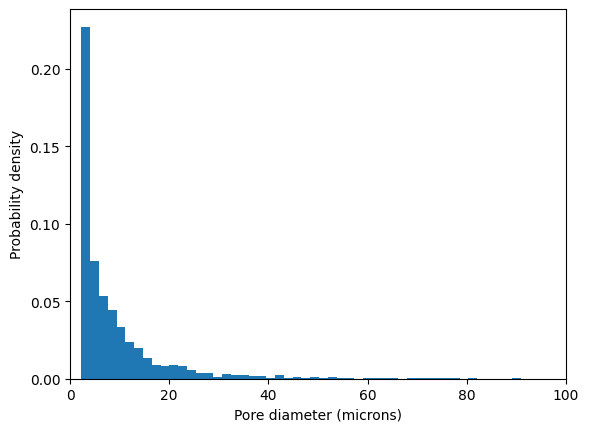

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
pore_diameter_data = []
for prefix in ["a06", "build-a-notch", "build-a-tension"]:
    for file in glob(f'data/sfc3/{prefix}*.csv'):
        pore_diameter_data = np.hstack((
            pore_diameter_data,
            np.genfromtxt(file, delimiter=',')[:, 3])
        )
fig = plt.figure()
vals, bins, _ = plt.hist(pore_diameter_data, bins=50, density=True)
_ = plt.xlabel('Pore diameter (microns)')
_ = plt.ylabel('Probability density')
_ = plt.xlim([0.,100.])
fig.set_dpi(100)
plt.show()

Create a cube to place the pores in, and add it to an element block:

In [2]:
from pcubit import cubit_init, cubit_cmd
cubit_init()
brick_length_in_meters = 3.6e-4
cubit_cmd(f'brick x {brick_length_in_meters}')
cubit_cmd('block 1 add volume 1')

ERROR: Intersection operation failed.
ERROR: ACIS API error number 21073 
ACIS API message = face containment cannot be determined 
ERROR: Intersection operation failed.
ERROR: ACIS API error number 21073 
ACIS API message = face containment cannot be determined 
Mean volume fraction is 0.0009016978134206428
which is within 0.1886459356269743%
of the target value 0.0009


Establish the desired pore statistics:

In [3]:
radiis = 1e-6/2*np.tile(bins[:-1] + np.diff(bins)/2, (3, 1)).T
probabilities = vals*np.diff(bins)
from pcubit import Statistics
statistics = Statistics(
    location='uniform random',
    radii=(radiis, probabilities),
    angles='uniform random'
)

Generate pores using a generalized Poisson point process based on the desired statistics:

In [4]:
from pcubit import Generator
generator = Generator(
    pore_statistics=statistics,
    target_pore_volume_fraction=9e-4,
    buffer=brick_length_in_meters/20
)
pores = generator()

Place all the pores within the geometry, merge anything unmerged, and choose the `ctet10` element:

In [5]:
pores.place()
cubit_cmd('merge all')
cubit_cmd('volume all scheme tetmesh')
cubit_cmd('block all element type tetra10')

Make a function to get the surface ids and surface areas for the cube sides, the rest being that for the pores:

In [6]:
import cubit
def get_surface_info():
    surface_ids = list(cubit.get_entities('surface'))
    surface_areas = []
    for surface_id in surface_ids:
        surface_areas.append(cubit.get_surface_area(surface_id))
    cube_surface_ids = []
    cube_surface_areas = []
    for dummy_index in range(6):
        max_area = max(surface_areas)
        max_area_id = surface_ids[np.argmax(surface_areas)]
        cube_surface_areas.append(max_area)
        cube_surface_ids.append(max_area_id)
        surface_ids.remove(max_area_id)
        surface_areas.remove(max_area)
    pores_surface_ids = surface_ids
    pores_surface_areas = surface_areas
    return cube_surface_ids, cube_surface_areas, pores_surface_ids, pores_surface_areas

Make a function to set the desired mesh sizes, which calls the previous function, then call it and mesh everything:

In [7]:
def set_desired_mesh_sizes(vol_size, rel_cube_surf_size, rel_pore_surf_size):
    cube_surface_ids, cube_surface_areas, \
        pores_surface_ids, pores_surface_areas = get_surface_info()
    cubit_cmd(f'volume all size {vol_size}')
    for surface_id in cube_surface_ids:
        cubit_cmd(f'surface {surface_id} '
                  f'size {rel_cube_surf_size*brick_length_in_meters}')
    for index, surface_id in enumerate(pores_surface_ids):
        cubit_cmd(f'surface {surface_id} '
                  f'size {rel_pore_surf_size*np.sqrt(pores_surface_areas[index])}')
set_desired_mesh_sizes(1e8, 1e-1, 3e-1)
cubit_cmd('mesh volume all')

Make a function to assign sidesets to the cube surfaces, andthen call it:

In [8]:
def sideset_fun(sideset_id, minimum, maximum):
    cubit.cmd(f'sideset {sideset_id} surface all patch '
              f'minimum {minimum[0]} {minimum[1]} {minimum[2]} '
              f'maximum {maximum[0]} {maximum[1]} {maximum[2]} ')
def make_sidesets(rel_tol=1e-4):
    h = brick_length_in_meters/2
    tol = rel_tol*h
    sideset_fun(1, [-h - tol, -h, -h], [-h + tol, +h, +h])
    sideset_fun(2, [+h - tol, -h, -h], [+h + tol, +h, +h])
    sideset_fun(3, [-h, -h - tol, -h], [+h, -h + tol, +h])
    sideset_fun(4, [-h, +h - tol, -h], [+h, +h + tol, +h])
    sideset_fun(5, [-h, -h, -h - tol], [+h, +h, -h + tol])
    sideset_fun(6, [-h, -h, +h - tol], [+h, +h, +h + tol])
make_sidesets()

The same statistical generator can be used repeatedly. Here, the statistics are validated:

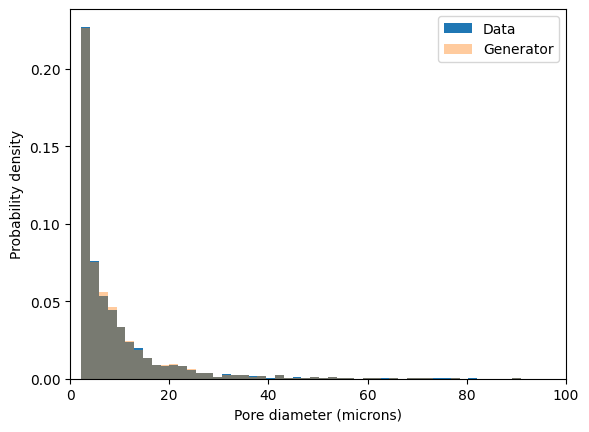

In [9]:
radiis = []
volume_fractions = []
for mesh_i in range(1000):
    cubit_cmd('reset')
    cubit_cmd(f'brick x {brick_length_in_meters}')
    cubit_cmd('block 1 add volume 1')
    pores = generator()
    pores.place()
    volume = cubit.get_volume_volume(cubit.get_entities('volume')[-1])
    volume_fractions.append(1 - volume/brick_length_in_meters**3)
    for pore in pores():
        radiis.append(pore.radii[0])
mean_volume_fraction = np.mean(volume_fractions)
rel_err = np.abs(100*(1 - mean_volume_fraction/generator.target_pore_volume_fraction))
print('Mean volume fraction is', mean_volume_fraction)
print('which is within', str(rel_err) + '%')
print('of the target value', generator.target_pore_volume_fraction)
fig = plt.figure()
_, bins, _ = plt.hist(pore_diameter_data, bins=50, density=True, label='Data')
_ = plt.hist(2e6*np.array(radiis), bins=bins, density=True, alpha=0.4, label='Generator')
_ = plt.xlabel('Pore diameter (microns)')
_ = plt.ylabel('Probability density')
_ = plt.xlim([0.,100.])
_ = plt.legend()
fig.set_dpi(100)
plt.show()

The pore volume fraction disribution can also be plotted:

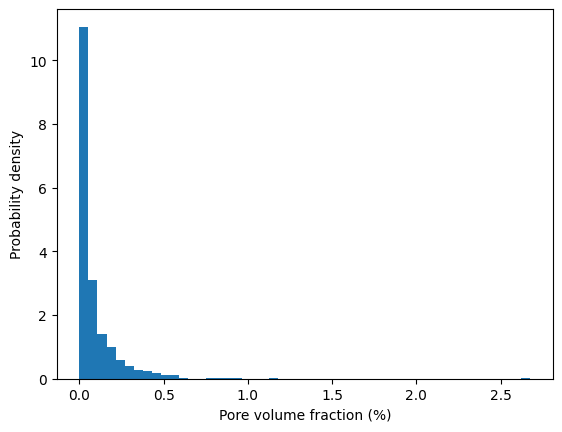

In [10]:
fig = plt.figure()
_ = plt.hist(1e2*np.array(volume_fractions), bins=50, density=True)
_ = plt.xlabel('Pore volume fraction (%)')
_ = plt.ylabel('Probability density')
fig.set_dpi(100)
plt.show()

Finally, construct a number of meshes and export them to a local folder:

In [11]:
import os
if not os.path.exists('./meshes/'):
    os.makedirs('./meshes/')
for mesh_i in range(0):
    cubit_cmd('reset')
    cubit_cmd(f'brick x {brick_length_in_meters}')
    cubit_cmd('block 1 add volume 1')
    generator().place()
    cubit_cmd('merge all')
    cubit_cmd('volume all scheme tetmesh')
    cubit_cmd('block all element type tetra10')
    set_desired_mesh_sizes(1e8, 1e-1, 3e-1)
    cubit_cmd('mesh volume all')
    make_sidesets()
    cubit_cmd(f'export mesh "./meshes/mesh_{mesh_i}.g" overwrite ')